# Zadanie 9

## Przygotowywania do zadania 

### Wczytywanie potrzebnych bibliotek

In [60]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import math

### Ustawianie globalnych danych

Ustawiam tutaj, dane które są uniwersalne dla każdego testu, to znaczy:

1. Liczba stopni swobody
2. Liczba danych
3. Liczba symulacji, które wykonam
4. Poziom istnotności


In [61]:
np.random.seed(123)

# Zakres stopni swobody, jakie zaprezentuję na wykresie
parametr_a = range(1, 50, 1)  # Zakres od 1-50 co 1
# Ustalam poziom istotności
poziom_istotnosci = 0.05
# Liczba danych dla jakich wykonam symulacje
liczby_danych = [10, 20, 50, 100, 200]
# Liczba symulacji na jakich będę bazować
liczba_symulacji = 100
# Czcionka dla tytulu
font_title = {'family' :'serif','size':17}

## Badanie 

### Potrzebne funkcje 

Tutaj stworzę wszystkie funkcje, które wykorzystam do badania, przy okazji opisując od razu ich działanie. Następnie przy symulacji badania, będą one tylko wywoływane. Funkcje zaczynają się od najbardziej ogólnej i idą w dół razem z programem(idziemy po kolei tak samo jak program).

#### Funkcja obliczania mocy testu 

Najogólniejsza funkcja, która przygotuje dane, które wykorzystam, aby zrobić symulacje w funkcji symulacja. Więc ustalamy liczbę danych oraz stopień swobody i idziemy dalej przekazując parametry dalej do funkcji. Po symulacji dodajemy wynik do tablicy i idziemy dalej. Od razu wybieram czy to będzie klasyczny sposób testowania czy z wykorzystaniem PIT oraz który rozkład jest teraz testowany. 

Argumenty: 
- rozkład - Mówi który rozkład jest symulowany
- PIT - Czy testujemy z wykorzystaniem PIT

Funkcja będzie zwracać tablice 2D(i,j), która zbierała dane dla i-tej liczbie danych oraz j-tych stopni swobody.



In [62]:
def obliczanie_mocy_testu(rozklad,PIT):
    # Tablica, która zbierze mi moce testów, które zwróci
    moce_testow = []

    # Dla każdej liczby z liczby_danych
    for l_danych in liczby_danych:
        """
        Tworzę nową tablicę która przechowuję wyniki mocu testu dla i-tej liczby danych. Lista przechowuje wyniki dla każdego j-stopnia
        swoobody w stopnie_swobody. Wykorzystuje List Comprahension, żeby umilic kod
        """
        moce_testow.append([symulacja(l_danych,par_a,rozklad,PIT) for par_a in parametr_a])



    # Zwracam w.w tablice
    return moce_testow

#### Funkcja symulacji 

Ustaliliśmy już liczbę danych oraz liczbe stopni swobody dla naszych danych. 
W tej funkcji będziemy generować dane z rozkładu rozklad dokładnie z tymi parametrami, przekazanymi jako argumenty. 
Następnie prześlemy je do funkcji, która wybierze, który test jest obecnie symulowany i wynik tej funkcji będziemy sumować w zmiennej 
suma_odrzucen_H0.

Argumenty:
- l_danych - Ile danych będziemy losować z rozkładu rozklad
- par_a - Wartosc parametru dla danego rozkladu
- rozklad - Jaki rozklad jest obecnie symulowany
- PIT - Czy testujemy z wykorzystaniem PIT

Funkcja będzie zwracać odsetek w jakim odrzuciłem hipotezę zerową dla podanych parametrów

In [63]:
def wybor_rozkladu(par_a,rozklad,l_danych):
    """
        Funkcja która sluzy do wybrania rozkladu ktory teraz symuluje(NIG/GAMMA)
    """
    probka = None
    if rozklad == "nig":
        probka = stats.norminvgauss.rvs(par_a+1,par_a,size=l_danych)
    else:
        probka = stats.gamma.rvs(par_a,size=l_danych)

    return probka

def symulacja(l_danych,par_a,rozklad,PIT):
    # W tej zmiennej będę sumował ile razy odrzuciłem hipotezę zerową dla danego zestawu 
    suma_odrzucenia_H0 = 0

    # Tutaj będzie symulacja
    for k in range(liczba_symulacji):
        # Tworzę próbkę danych z rozkładu t-Studenta o l_danych wielkości oraz s_stopien stopni swobody
        probka = wybor_rozkladu(par_a,rozklad,l_danych)

        # Następnie przekazuje wszystkie dane, aby wybrac który test jest symulowany i dowiedzieć się jaki jest wynik testu
        suma_odrzucenia_H0 += wybor_testu(probka,rozklad,par_a,PIT)

    # Zwracam odsetek odrzucenia hipotezy zerowej
    return suma_odrzucenia_H0/liczba_symulacji

#### Funkcja wyboru testu 

Funkcja za argumenty przyjmuje wszystkie dane, które są jej potrzebne do wybrania oraz przeprowadzenia danego testu. 
Argumenty, to:

- probka - Zestandaryzowany zestaw danych, które będziemy badać
- PIT - Jaki sposob testowania
- par_a - Wartosc parametru a rozkladu

Funkcja będzie zwracać 1 lub 0 w zależności od wyniku testu(1-odrzucamy test, 0-nie ma podstaw)

In [64]:

def wybor_testu(probka,rozklad,par_a,PIT):

    """
    Ogólna zasada działania testów:
    
    Jezali PIT jest true to wykorzystujemy je do testowania co znaczy ze przeksztalcamy probke na Fx(x)
    i porownujemy ja z rozkladem jednostajnym. Jezeli nie to mamy do czynienia z klasycznym sposobem 
    testowania i postepujemy normalnie.

    Jeżeli pvalue z danego testu jest mniejsze niż wczesniej ustalony poziom istotnotnosci to odrucamy 
    Hipoteze zerowa co znaczy ze zwracamy wartość 1. W przeciwnym wypadku zwracamy 0
    
    """
    # Najpierw podejmiemy wybór jaki test mamy wykonać

    # Test Kolgomorova
    pval = None
    
    # Proceudra PIT
    if PIT:
        # Wybór rozkładu
        if rozklad == "nig":
            # Zamiana na Fx(x)
            probka = stats.norminvgauss.cdf(probka,par_a+1,par_a)
            # Uzyskanie pvalue
            pval = stats.kstest(probka,'uniform').pvalue
        else:
            # To samo co dla nig tylko dla gammy
            probka = stats.gamma.cdf(probka,par_a)
            pval = stats.kstest(probka,'uniform').pvalue

    # Normalny sposob testowania  
    else:
        if rozklad == "nig":
            pval = stats.kstest(probka,'norminvgauss',args=(par_a+1,par_a,)).pvalue
        else:
            pval = stats.kstest(probka,'gamma',args=(par_a,)).pvalue 
    
    # Po uzyskaniu pvalue sprawdzam wartosc 
    if pval <0.05: return 1          

    # Jeżeli do tej pory nie zwrócono 1 to znaczy, że żaden z testów nie odrzucił H0 więc możemy zwrócic 0
    return 0
            


## Symulacje 

### Klasyczny sposób testowanaia

In [65]:
moc_kol_nig = obliczanie_mocy_testu("nig",False)
moc_kol_gamma = obliczanie_mocy_testu("gamma",False)


### Testowanie z wykorzystaniem PIT

In [66]:
moc_kol_nig_pit = obliczanie_mocy_testu("nig",True)
moc_kol_gamma_pit = obliczanie_mocy_testu("gamma",True)


## Wnioski 

### Test Kołgomorowa - Rozkład gamma 

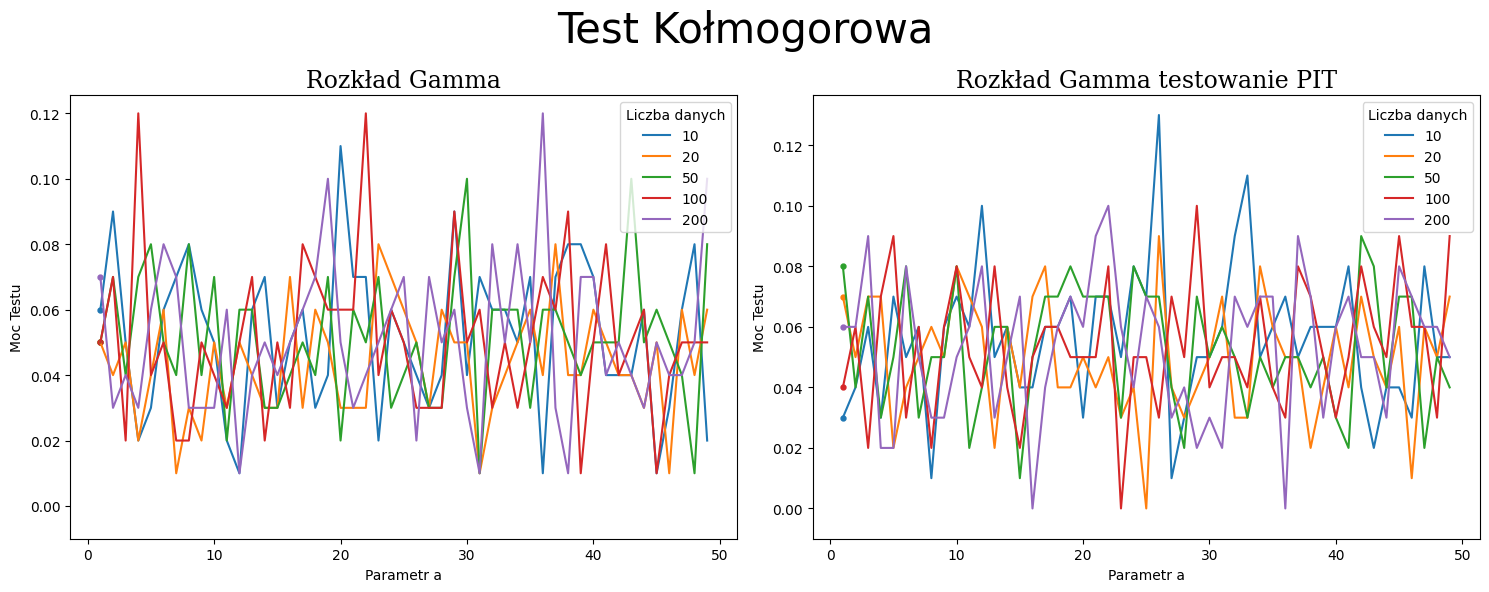

In [71]:
fig, (kol,kol_pit) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns

# Dodaje dane do wykres
for i,moc in enumerate(moc_kol_gamma):
    kol.plot(parametr_a,moc,label= str(liczby_danych[i]))
    kol.scatter(parametr_a[0], moc[0], s=50, marker='.') 

for i,moc in enumerate(moc_kol_gamma_pit):
    kol_pit.plot(parametr_a,moc,label= str(liczby_danych[i]))
    kol_pit.scatter(parametr_a[0], moc[0], s=50, marker='.') 


# Dodaje opisy do wykresu test kolgomorowa
kol.set_xlabel("Parametr a")
kol.set_ylabel("Moc Testu")
kol.set_title("Rozkład Gamma",fontdict=font_title)
kol.legend(title="Liczba danych",loc="upper right")
kol.set_ylim(-0.01)

# Dodaje opisy do wykresu 
kol_pit.set_xlabel("Parametr a")
kol_pit.set_ylabel("Moc Testu")
kol_pit.set_title("Rozkład Gamma testowanie PIT",fontdict=font_title)
kol_pit.legend(title="Liczba danych",loc="upper right")
kol_pit.set_ylim(-0.01)

fig.suptitle("Test Kołmogorowa",fontsize =30)
plt.tight_layout()
plt.show()


### Wnioski

Jak możemy zauważyć na wykresie test kołgomorowa jest bardzo dokładny . Test jest na tyle dokladny, że nie ma żadnej różnicy w sposobie testowania(klasyczne a testowanie wykorzystująć PIT (probability integral transform)). 

### Test Kołmogorowa - Rozkład NIG


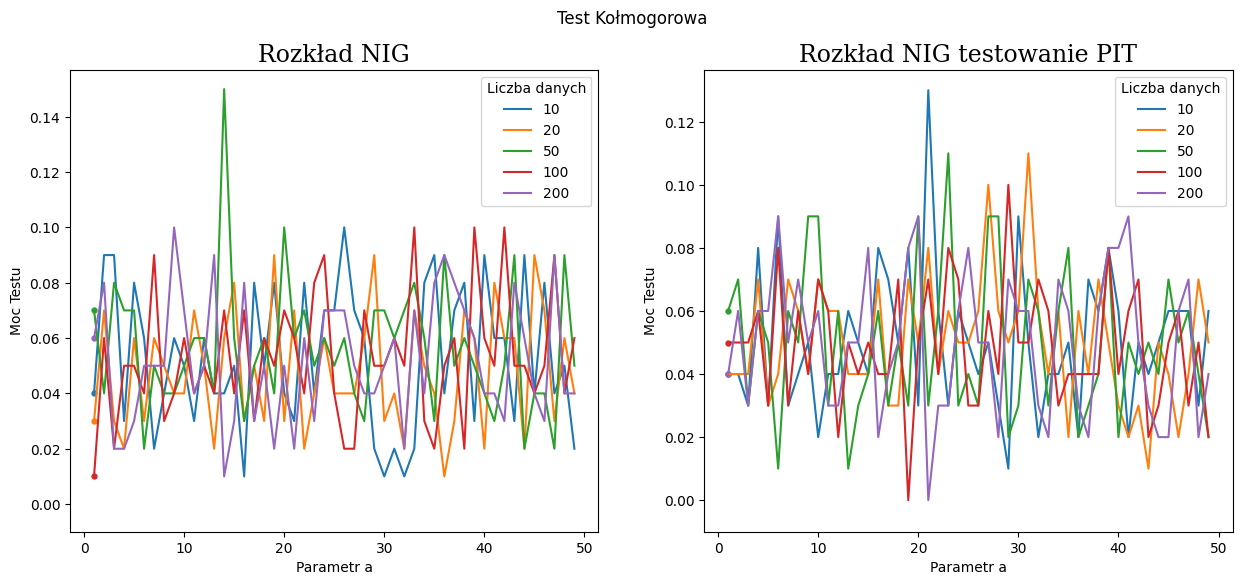

In [72]:
fig, (kol,kol_pit) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns

# Dodaje dane do wykres
for i,moc in enumerate(moc_kol_nig):
    kol.plot(parametr_a,moc,label= str(liczby_danych[i]))
    kol.scatter(parametr_a[0], moc[0], s=50, marker='.') 

for i,moc in enumerate(moc_kol_nig_pit):
    kol_pit.plot(parametr_a,moc,label= str(liczby_danych[i]))
    kol_pit.scatter(parametr_a[0], moc[0], s=50, marker='.') 


# Dodaje opisy do wykresu test kolgomorowa
kol.set_xlabel("Parametr a")
kol.set_ylabel("Moc Testu")
kol.set_title("Rozkład NIG",fontdict=font_title)
kol.legend(title="Liczba danych",loc="upper right")
kol.set_ylim(-0.01)

# Dodaje opisy do wykresu 
kol_pit.set_xlabel("Parametr a")
kol_pit.set_ylabel("Moc Testu")
kol_pit.set_title("Rozkład NIG testowanie PIT",fontdict=font_title)
kol_pit.legend(title="Liczba danych",loc="upper right")
kol_pit.set_ylim(-0.01)

fig.suptitle("Test Kołmogorowa")
# plt.tight_layout()
plt.show()

### Wnioski

Jak możemy zauważyć na wykresie test kołgomorowa jest bardzo dokładny . Test jest na tyle dokladny, że nie ma żadnej różnicy w sposobie testowania(klasyczne a testowanie wykorzystująć PIT (probability integral transform)). 